# Customer Lifetime Value(CLV)

The Customer lifetime value model is a key technique in customer analytics which evaluates the total revenue a business can expect from a single customer. Businesses use this metric to identify significant customer segments that are the most valuable to the company. It can help businesses make decisions about how much money to invest in acquiring new customers and how much they;re willing to spend to retain existing ones. Neglecting CLV can lead to overinvestment in short-term customers who may only make a single purchase. It can be expressed by <br>
<br>
![](https://delighted.com/wp-content/uploads/2022/06/calculation-clv-2-2x.png)

In this notebook, CLV is estimated using the python CLV modeling library [PyMCLabs](https://github.com/pymc-labs/pymc-marketing), a successor of a popular CLV library [lifetimes](https://github.com/CamDavidsonPilon/lifetimes/tree/master?tab=readme-ov-file). <br>

The '**Buy Till You Die**' model, which utilizes the beta geometric/negatvie binomial distribution (BG/NBD) and Gamma-gamma models can estimate CLV. <br> 

* BG-NBD model: This predicts the likelihood of a customer being active and their transaction frequency.

* Gamma-Gamma model: This estimates the average order value. The gamma distribution is shaped by two parameters: the shape parameter $k$ and the scale parameter $\theta$. 
    * The first gamma distribution represents the average order value for each customer
    * The second gamma distribution represents the variation in average order value across the entire customer.   


In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ydata_profiling
from arviz.labels import MapLabeller

from pymc_marketing import clv

%matplotlib inline

In [2]:
az.style.use('arviz-darkgrid')

%config InlineBackend.figure_format = 'retina'

Three main objectives:
1. Calculate and predict future CLV, which will help you find out how much money can be expected from each customer
2. Identify profitable customers. The model will tell you who those valuable customers are by analyzing the characteristics of the high CLV customers
3. Take marketing actions based on the analysis

The sample [online retail dataset](https://archive.ics.uci.edu/dataset/352/online+retail) is downloaded from UC Irvine Machine Learning Repository

In [3]:
csv_file = './data/online_retail.csv'
data_raw = pd.read_csv(csv_file)

data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data profiling

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data_raw.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
data_raw.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
data = data_raw[(data_raw['UnitPrice'] > 0) & (data_raw['Quantity'] > 0)]

data = data[data['CustomerID'].notna()]

data['purchase_amount'] = data['Quantity']*data['UnitPrice']

transaction_data = data.groupby(['CustomerID','InvoiceDate'])['purchase_amount'].sum().reset_index()
transaction_data.head()

,CustomerID,InvoiceDate,purchase_amount
0,12346.0,2011-01-18 10:01:00,77183.60
1,12347.0,2010-12-07 14:57:00,711.79
2,12347.0,2011-01-26 14:30:00,475.39
3,12347.0,2011-04-07 10:43:00,636.25
4,12347.0,2011-06-09 13:01:00,382.52


In [8]:
transaction_data.isna().sum()

CustomerID         0
InvoiceDate        0
purchase_amount    0
dtype: int64

In [9]:
ydata_profiling.ProfileReport(transaction_data, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")]

cancelled_orders.loc[:,'Quantity'] = -cancelled_orders['Quantity']

merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']],
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'],
                       how='left', indicator=True)

data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

data_raw = data_raw.drop(columns=['_merge'])

features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data.loc[:,'TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

data = data[data['CustomerID'].notna()]
data.loc[:,'CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

/tmp/ipykernel_663/640313456.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])
/tmp/ipykernel_663/640313456.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['17850' '17850' '17850' ... '12680' '12680' '12680']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[:,'CustomerID'] = data['CustomerID'].astype(int).astype(str)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


##  RFM-T data table

RFM-T stands for Recency, Frequency, Monetary, and Tenure of each customer.

* `customer_id` represents a unique identifier for each customer.

* `frequency` represents the number of repeat purchases that a customer has made, i.e. one less than the total number of purchases.

* `T` represents a customer’s “age”, i.e. the duration between a customer’s first purchase and the end of the period of study. In this example notebook, the units of time are in weeks.

* `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;

* `monetary_value` represents the average value of a given customer’s repeat purchases. Customers who have only made a single purchase have monetary values of zero.

Note that the term `recency` may confuse you when you interpret a result. In RFM analysis, recency represents the timepoint between reference point (an end of the observation period) and the last purchase. However, the `recency` in this python package represents the first and last transaction.  

In [11]:
data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

/usr/local/lib/python3.11/site-packages/pymc_marketing/clv/utils.py:286: UserWarning: clv_summary was renamed to rfm_summary
  warnings.warn("clv_summary was renamed to rfm_summary", UserWarning, stacklevel=1)


,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12349,12349,0.0,0.0,18.0,0.000000
12350,12350,0.0,0.0,310.0,0.000000
12352,12352,5.0,260.0,296.0,221.756000


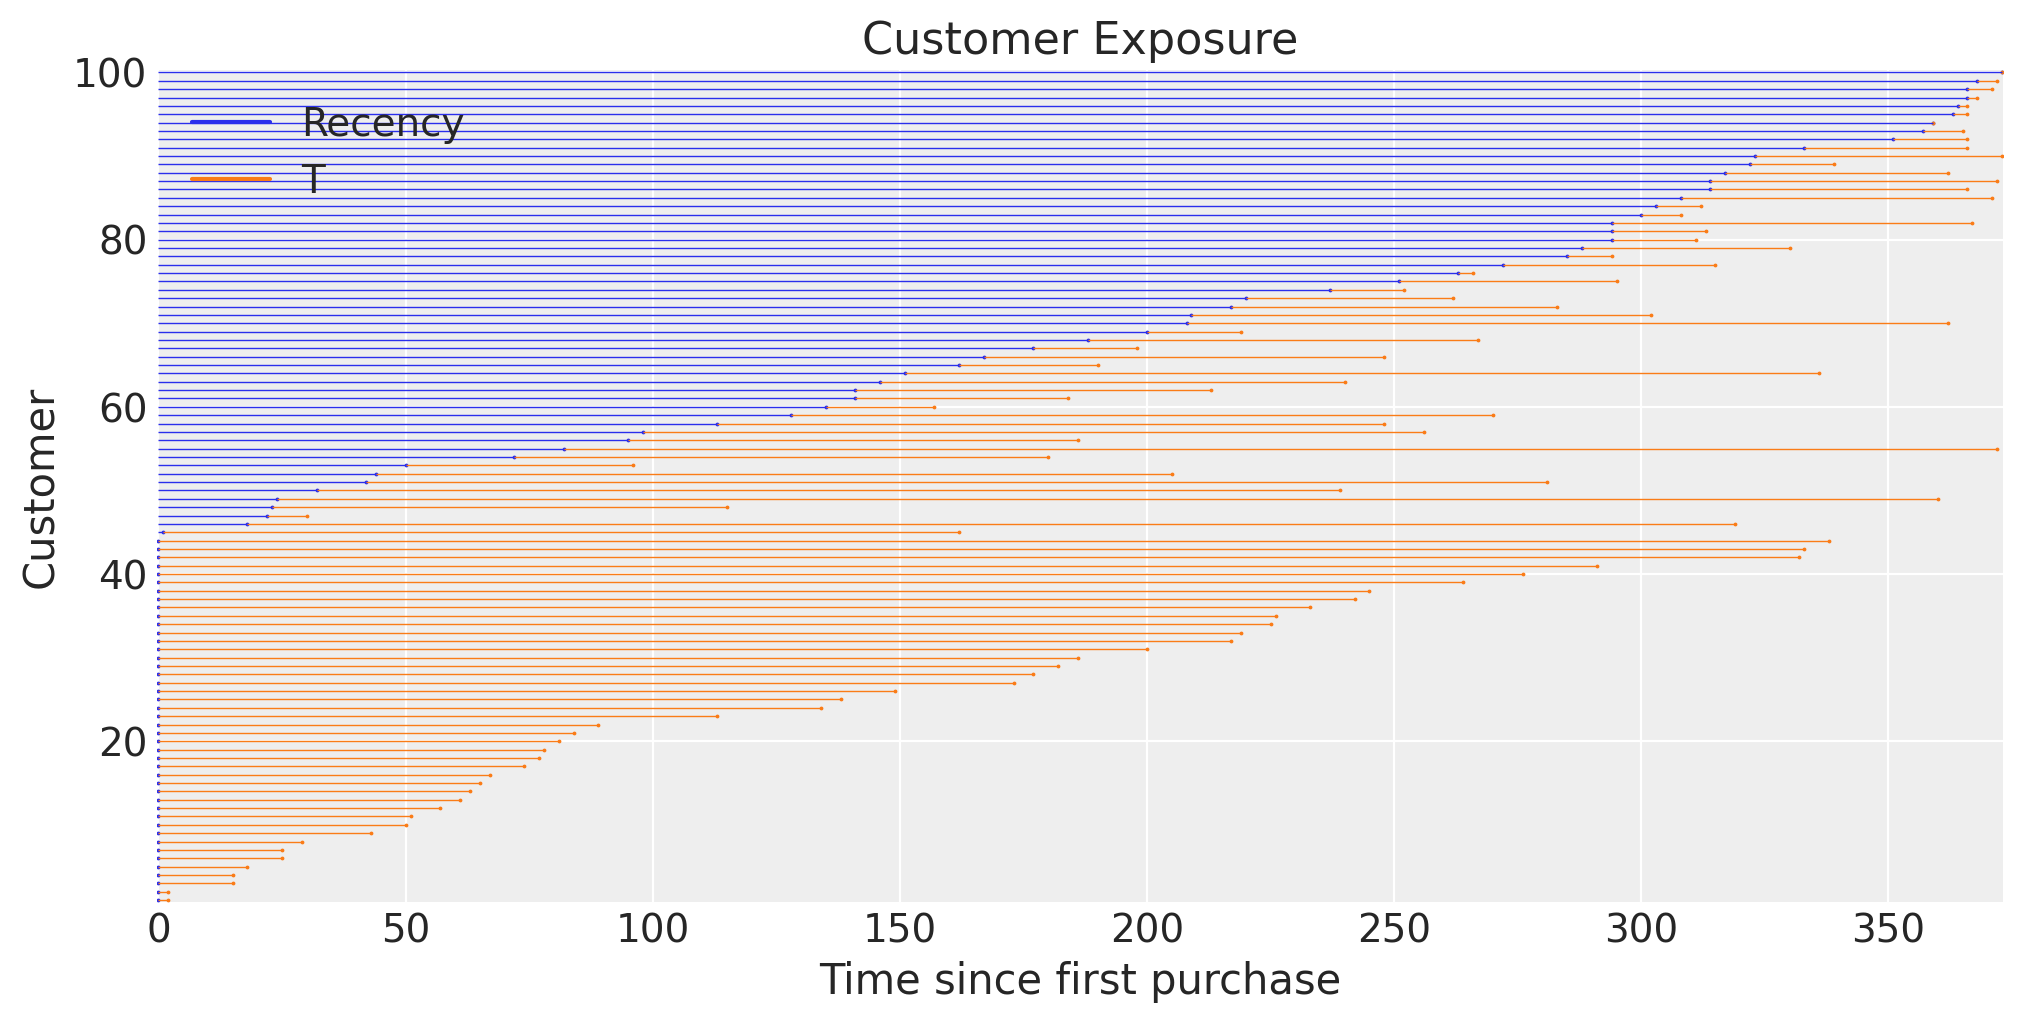

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data_summary_rfm
    .sample(n=100, random_state=42)
    .sort_values(['recency', 'T'])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

Roughly speaking, the half of customers has not made another transaction.

BG/NBD model - is a probabilistic model taht predicts the number of repeat purchases a customer will make. 
This model can only predict the future transactions and churn rate of a customer ($1- AliveProbability$).

Gamma-gamma mode - is used to predict the average transaction value for each customer.

## Frequency/Recency analysis using the BG-NBD model

The BG-NBD model predicts the probability-of-being-alive p as well as number of purchases in the next k periods. These two predictions can in turn be used to calculate a rough estimate of the customer’s value for the next k periods.

* This estimate relies on the following two simplistic assumptions:

    * The probability-of-being-alive p remains unchanged in the next k periods
    * The average value of purchases in the next k periods equals the average purchase values in the observation period.

In reality, p usually changes after every purchase and the future purchase value might diverge significantly from the past values. As such, the resulting estimate is a rough one. Should you be interested, more sophisticated probabilistic models such as the Gamma-Gamma model exist that can calculate the future purchase value in a more rigorous manner


**Reference**
>Fader, Peter S., Bruce GS Hardie, and Ka Lok Lee. ““Counting your customers” the easy way: An alternative to the Pareto/NBD model.” Marketing science 24.2 (2005): 275-284. http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

In [18]:
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()

bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1650 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.449056e+05,5.954746e+05,7.618240e+02,1.376169e+06,2.965439e+05,2.270581e+05,4.0,14.0,3.42
alpha,7.242900e+01,1.428000e+00,6.996600e+01,7.338700e+01,7.110000e-01,5.450000e-01,4.0,11.0,3.80
b,7.078618e+10,1.440837e+10,5.398753e+10,8.612338e+10,7.175309e+09,5.493998e+09,4.0,11.0,3.96
r,8.550000e-01,1.300000e-02,8.360000e-01,8.700000e-01,6.000000e-03,5.000000e-03,4.0,14.0,3.62


### Info: select prior distribution

The default priors for the 4 parameters follow a HalfFlat distribution. The HalfFlat distribution can be replaced with the HalfNormal distribution with a standard deviation of 10.
> A HalfFlat distribution is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

In [19]:
# model_config = {
#     'a_prior': {'dist': 'HalfNormal',
#                 'kwargs': {'sigma': 10}},
#     'b_prior': {'dist': 'HalfNormal',
#                 'kwargs': {'sigma': 10}},
#     'alpha_prior': {'dist': 'HalfNormal',
#                 'kwargs': {'sigma': 10}},
#     'r_prior': {'dist': 'HalfNormal',
#                 'kwargs': {'sigma': 10}},
# }

In [21]:
# bgm = clv.BetaGeoModel(
#     data = data_summary_rfm,
# )
# bgm.build_model()

# bgm.fit()
# bgm.fit_summary()

## Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

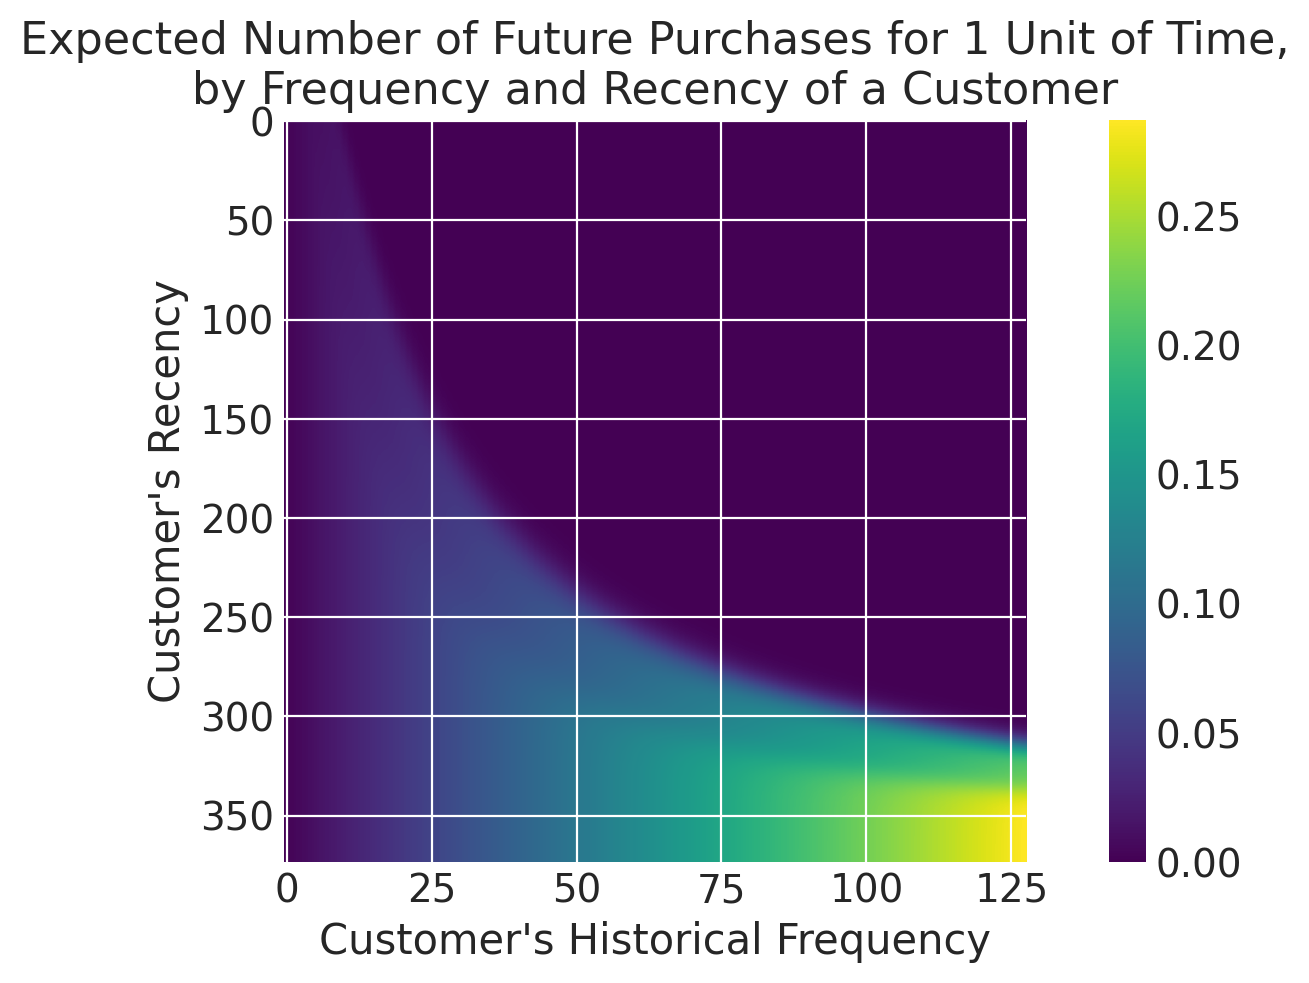

In [22]:
clv.plot_frequency_recency_matrix(bgm)

## Probability Alive Matrix

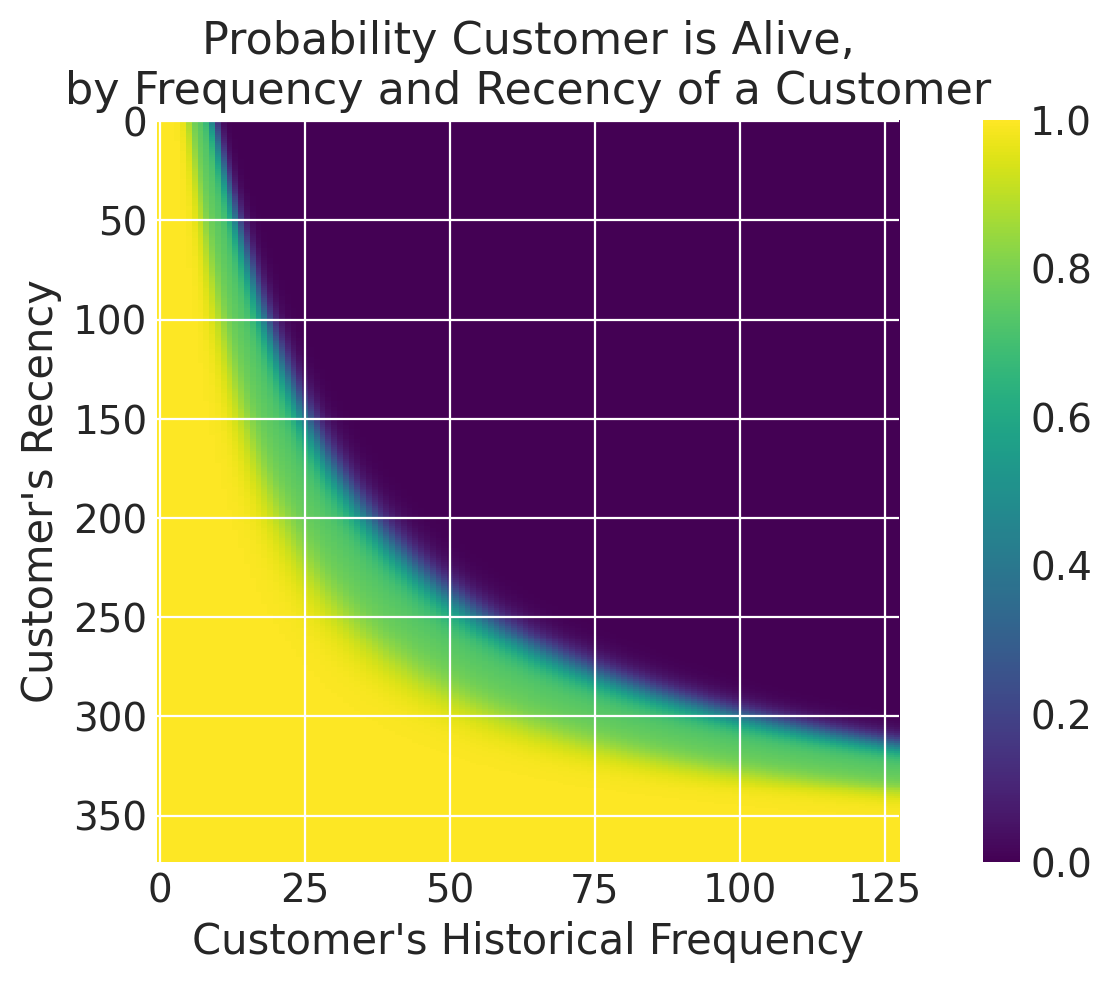

In [23]:
clv.plot_probability_alive_matrix(bgm);

**Interpretation of the graph**

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*6P1EPzQtSslEEoLB.png)

1. [Customer Lifetime Value Prediction with PyMC-Marketing](https://towardsdatascience.com/pymc-marketing-the-key-to-advanced-clv-customer-lifetime-value-forecasting-bc0730973c0a) <br>

## Estimate future transaction per customer

In [24]:
num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm['customer_id'],
    t=365,
    frequency=data_summary_rfm['frequency'],
    recency=data_summary_rfm['recency'],
    T=data_summary_rfm['T']
)

sdata = data_summary_rfm.copy()
sdata['expected_purchases'] = num_purchases.mean(('chain', 'draw')).values
sdata.sort_values(by='expected_purchases').tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
customer_id,,,,,,
15311,15311,89.0,373.0,373.0,660.002809,73.614379
17841,17841,111.0,372.0,373.0,341.128018,91.633034
12748,12748,112.0,373.0,373.0,284.600893,92.452179
14911,14911,127.0,372.0,373.0,953.531890,104.736368


### Calculate historical probability of being alive 

Given a customer transaction history, their historical probability of being alive can be computed using the trained model.

In [25]:
data_summary_rfm[(data_summary_rfm['frequency'] > 3) & (data_summary_rfm['recency'] < 70)]

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12685,12685,5.0,65.0,93.0,462.768000
12856,12856,5.0,56.0,63.0,357.238000
12912,12912,4.0,38.0,40.0,336.060000
13685,13685,5.0,58.0,60.0,357.056000
13755,13755,7.0,60.0,63.0,237.955714
13882,13882,4.0,62.0,64.0,234.630000
14102,14102,4.0,39.0,44.0,226.770000
14251,14251,4.0,56.0,57.0,405.060000
14434,14434,5.0,51.0,72.0,212.400000


In [26]:
custID = '15993'
sample_customer = data_summary_rfm.loc[custID]
sample_customer

customer_id         15993
frequency             4.0
recency              36.0
T                    44.0
monetary_value    372.085
Name: 15993, dtype: object

In [27]:
start = 0
stop = 100
step = 10
n = len(np.arange(start,stop,step))


sample_customer_history = pd.DataFrame(dict(
    ID=np.full(n, custID, dtype='int'),
    frequency=np.full(n, sample_customer['frequency'], dtype='int'),
    recency=np.full(n, sample_customer['recency']),
    T=(np.arange(start, stop,step) + sample_customer['recency']).astype('float'),

))
sample_customer_history

,ID,frequency,recency,T
0,15993,4,36.0,36.0
1,15993,4,36.0,46.0
2,15993,4,36.0,56.0
3,15993,4,36.0,66.0
4,15993,4,36.0,76.0
5,15993,4,36.0,86.0
6,15993,4,36.0,96.0
7,15993,4,36.0,106.0
8,15993,4,36.0,116.0
9,15993,4,36.0,126.0


In [28]:
p_alive = bgm.expected_probability_alive(
    customer_id=sample_customer_history['ID'],
    frequency=sample_customer_history['frequency'],
    recency=sample_customer_history['recency'],
    T=sample_customer_history['T'],
)

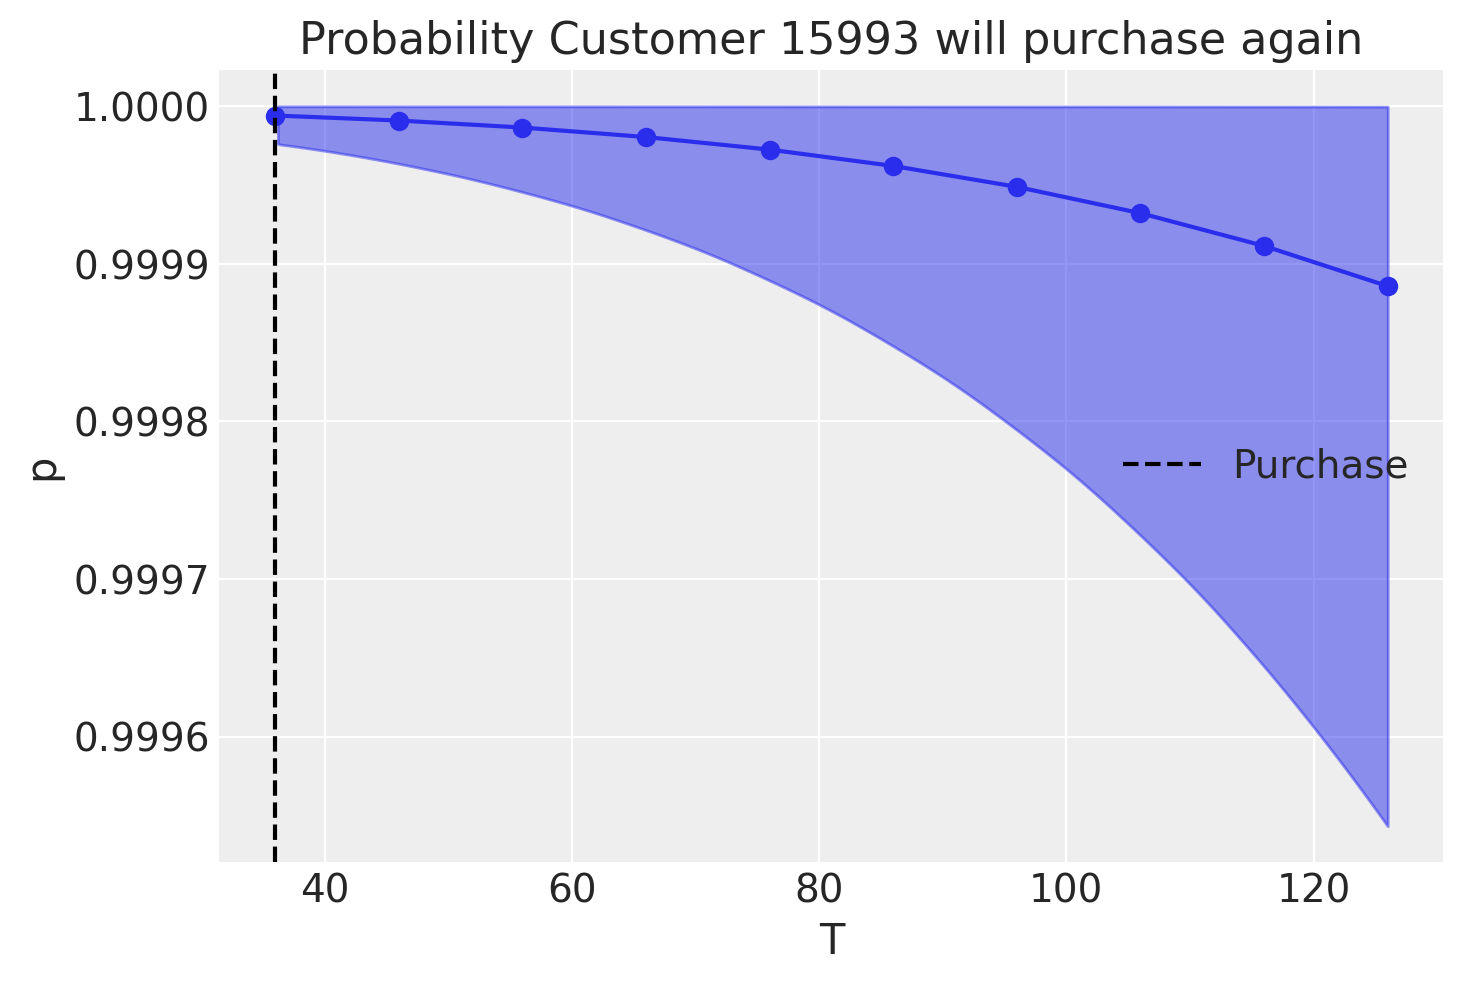

In [29]:
az.plot_hdi(sample_customer_history['T'], p_alive, color='C0')
plt.plot(sample_customer_history['T'], p_alive.mean(('draw', 'chain')), marker='o')
plt.axvline(sample_customer_history['recency'].iloc[0], c='black', ls='--', label='Purchase')

plt.title(f'Probability Customer {custID} will purchase again')
plt.xlabel('T')
plt.ylabel('p')
plt.legend();

## CLV estimation using the Gamma-Gamma model

The gamma-gamma model is used to predict the average order value. <br>

The Gamma-Gamma model assumes
1. *at least 1* repeat transaction has been made per customer
2. There is no relationship between the monetary value and the purchase frequency
    * In practice, check whether the Pearson correlation is less than 0.3

In [30]:
nonzero_data = data_summary_rfm.query('frequency>0')

In [31]:
nonzero_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.134788
frequency,0.134788,1.000000


The transaction frequencies and monetary values are uncorrelated.

In [32]:
dataset = pd.DataFrame({
    'customer_id': nonzero_data.customer_id,
    'mean_transaction_value': nonzero_data['monetary_value'],
    'frequency': nonzero_data['frequency'],
})
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [33]:
gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,2.083,0.110,1.876,2.291,0.003,0.002,1121.0,1671.0,1.0
q,3.585,0.152,3.305,3.886,0.004,0.003,1349.0,1530.0,1.0
v,511.960,45.414,429.426,597.245,1.380,0.993,1102.0,1522.0,1.0


### Predicting spend value of customers

In [34]:
expected_spend = gg.expected_customer_spend(
    customer_id=data_summary_rfm['customer_id'],
    mean_transaction_value=data_summary_rfm['monetary_value'],
    frequency=data_summary_rfm['frequency'],
)

In [35]:
az.summary(expected_spend.isel(customer_id=range(10)), kind='stats')

,mean,sd,hdi_3%,hdi_97%
x[12347],567.264,3.178,561.221,573.193
x[12348],333.531,2.433,329.127,338.283
x[12349],411.056,7.379,397.146,424.833
x[12350],411.056,7.379,397.146,424.833
x[12352],259.433,2.679,254.343,264.296
x[12353],411.056,7.379,397.146,424.833
x[12354],411.056,7.379,397.146,424.833
x[12355],411.056,7.379,397.146,424.833
x[12356],323.924,3.386,317.887,330.688
x[12357],411.056,7.379,397.146,424.833


### Expected average order value with high density interval

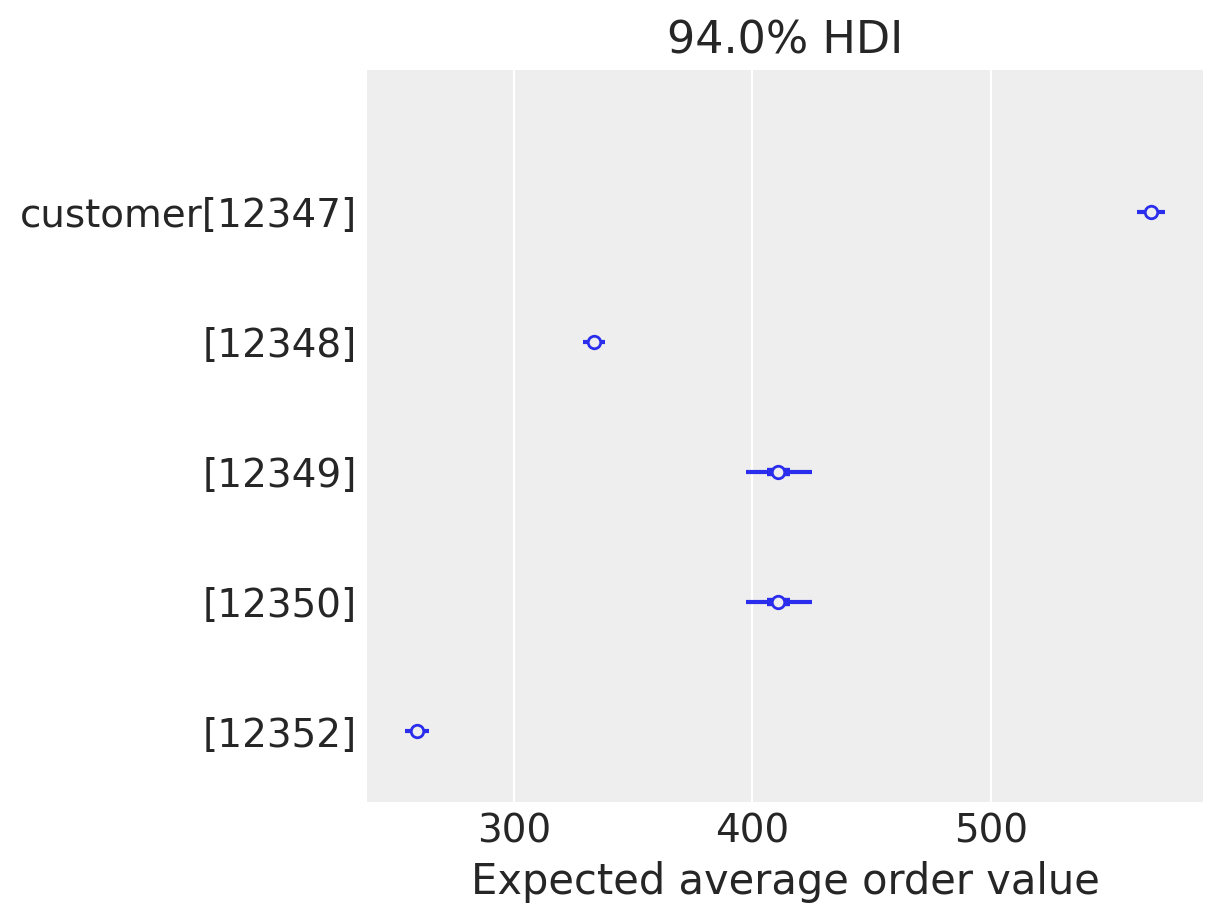

In [36]:
labeller = MapLabeller(var_name_map={'x': 'customer'})
az.plot_forest(expected_spend.isel(customer_id=(range(5))), combined=True, labeller=labeller)
plt.xlabel('Expected average order value');

The average expected mean spend across all customers

In [37]:
az.summary(expected_spend.mean('customer_id'), kind='stats')

,mean,sd,hdi_3%,hdi_97%
x,417.808,4.18,409.869,425.578


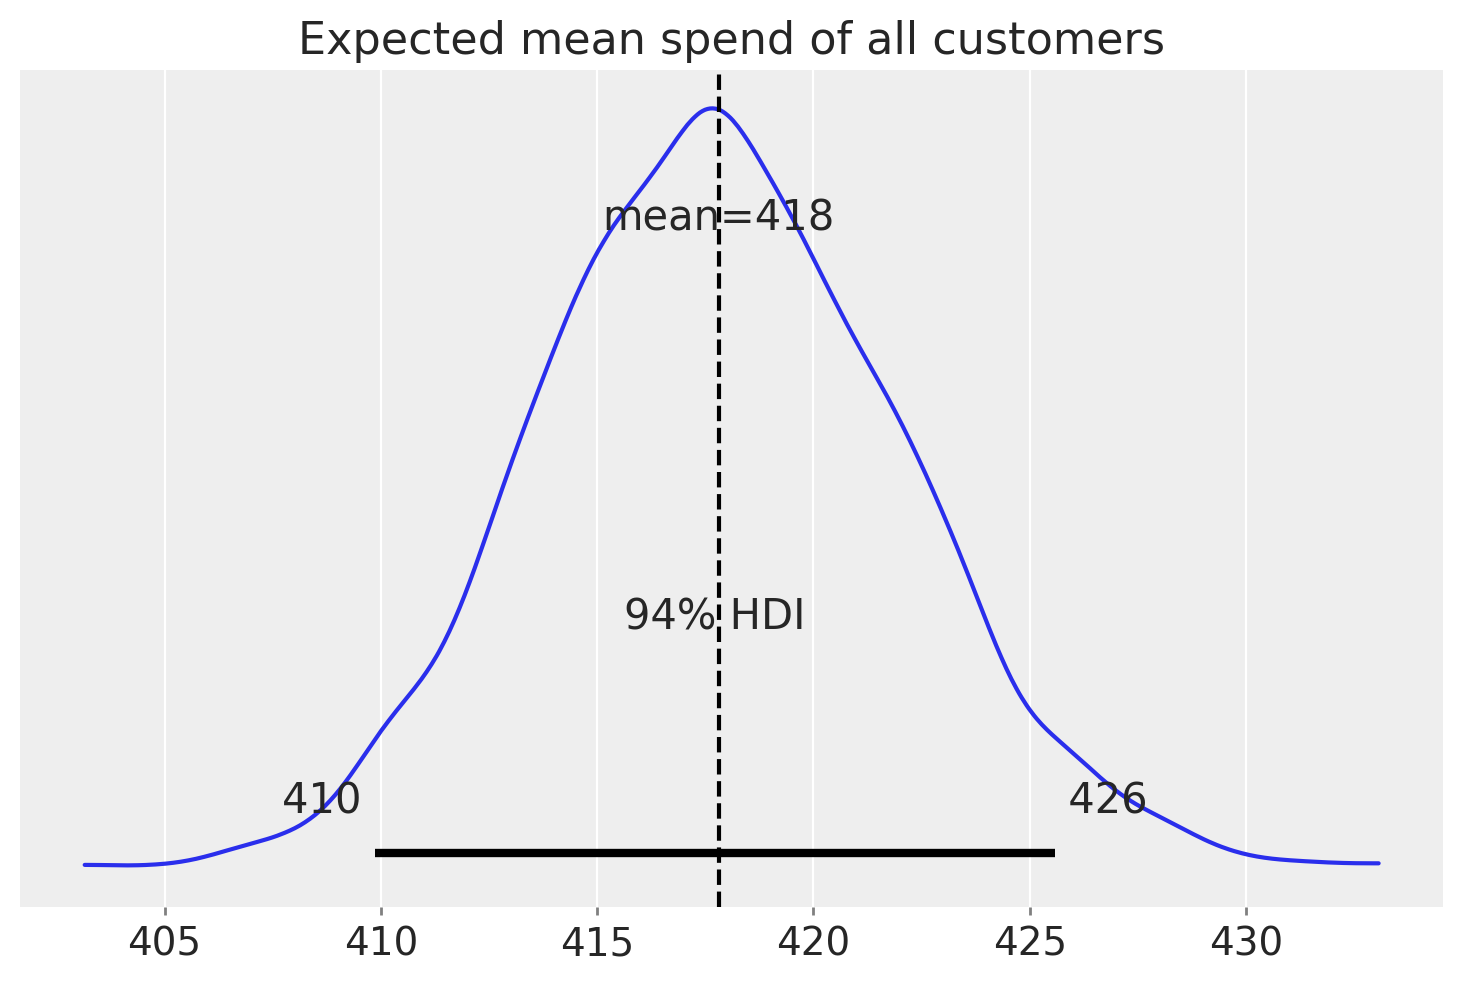

In [38]:
az.plot_posterior(expected_spend.mean('customer_id'))
plt.axvline(expected_spend.mean(), color='k', ls='--')
plt.title('Expected mean spend of all customers');

### Predicting spend of value of a new customer

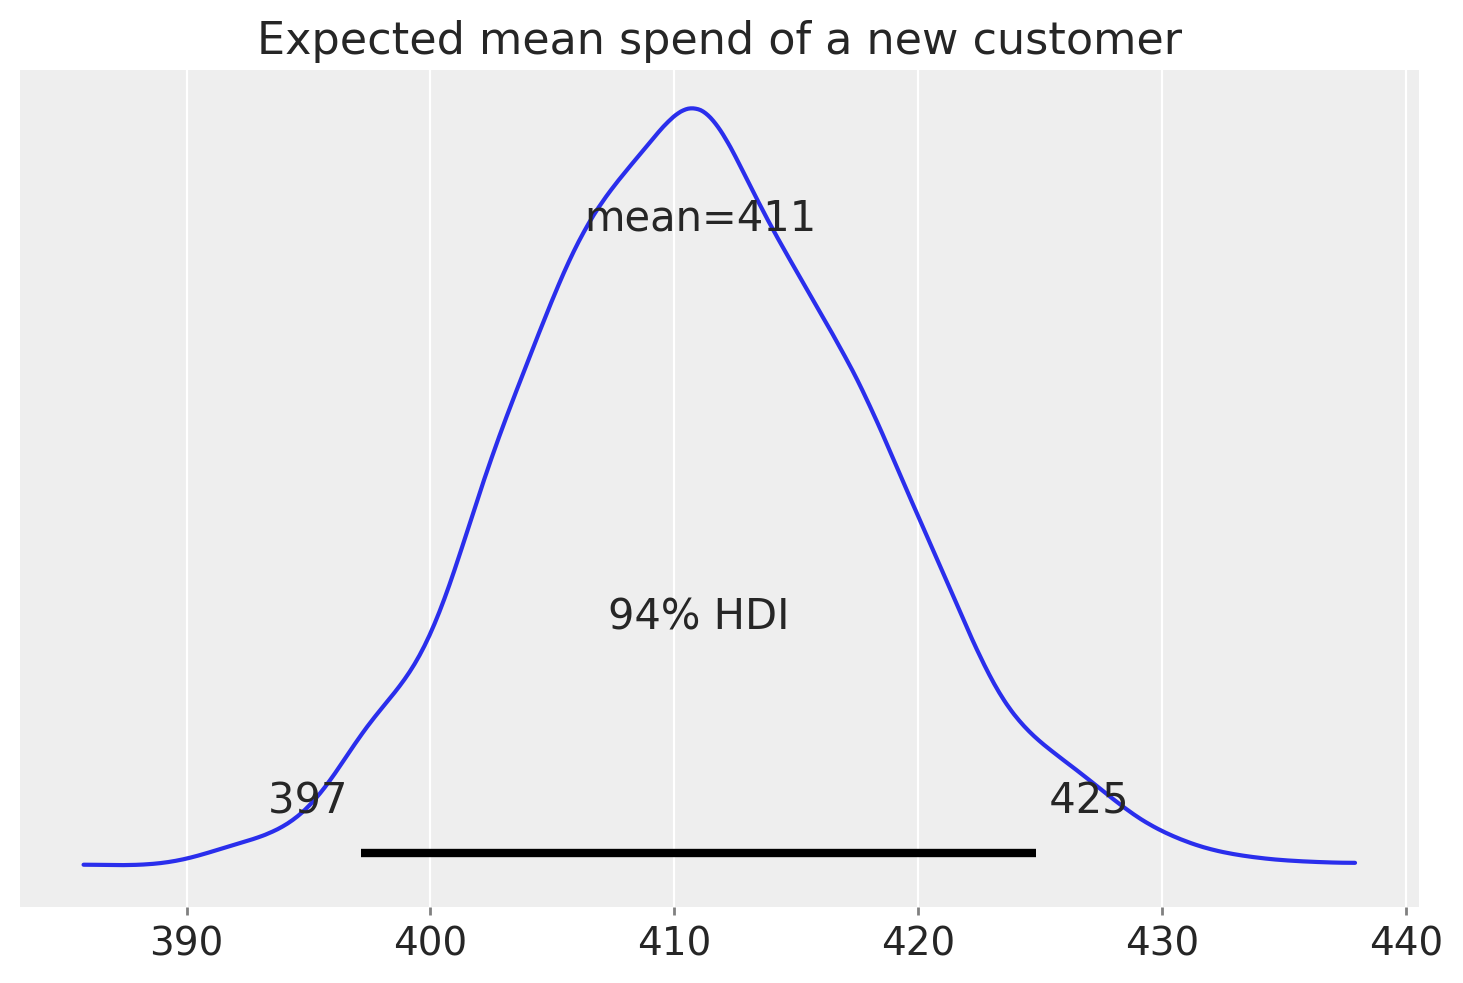

In [39]:
az.plot_posterior(
    gg.expected_new_customer_spend()
)
plt.title('Expected mean spend of a new customer');

### CLV estimation

Finally, the Gamma-Gamma model is combined with the BG/NBD model to estimate the customer lifetime value for each customer. This relies on the [Discount cash flow model](https://www.investopedia.com/terms/d/dcf.asp), adjusting for cost of capital. <br>
<br>
![](./CLV_modeling.png)

In [40]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=data_summary_rfm['customer_id'],
    mean_transaction_value=data_summary_rfm['monetary_value'],
    frequency=data_summary_rfm['frequency'],
    recency=data_summary_rfm['recency'],
    T=data_summary_rfm['T'],
    time=120, # 120 months = 10 years
    discount_rate=0.01,
    freq='D',
)

In [41]:
az.summary(clv_estimate.isel(customer_id=range(10)), kind='stats')

,mean,sd,hdi_3%,hdi_97%
x[12347],18500.857,108.345,18304.310,18711.446
x[12348],6245.463,46.245,6163.388,6335.109
x[12349],8125.193,156.245,7816.464,8401.755
x[12350],1921.396,41.023,1847.048,1998.157
x[12352],8619.489,89.995,8458.803,8793.353
x[12353],2658.120,55.185,2556.990,2759.617
x[12354],2413.655,50.562,2320.659,2506.455
x[12355],2565.325,53.438,2467.412,2663.570
x[12356],4865.193,51.625,4766.441,4957.868
x[12357],6969.102,133.003,6710.907,7206.544


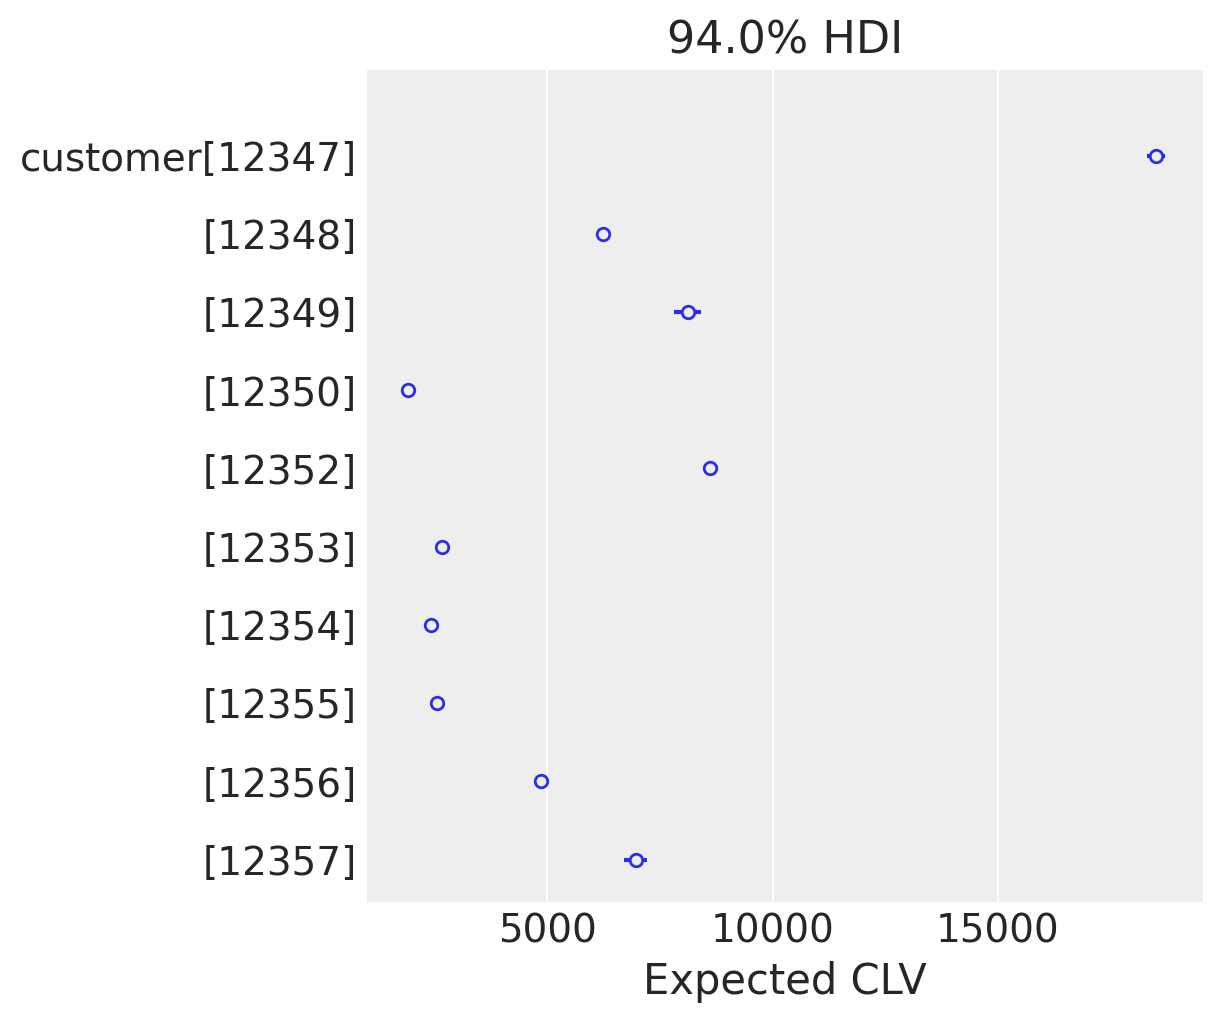

In [42]:
az.plot_forest(clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller)
plt.xlabel('Expected CLV');

In [43]:
clv_df = az.summary(clv_estimate, kind="stats").reset_index()

clv_df['customer_id'] = clv_df['index'].str.extract('(\d+)')[0]

clv_df = clv_df[['customer_id', 'mean', 'hdi_3%', 'hdi_97%']]
clv_df.rename(columns={'mean' : 'clv_estimate', 'hdi_3%': 'clv_estimate_hdi_3%', 'hdi_97%': 'clv_estimate_hdi_97%'}, inplace=True)

monetary_values = data_summary_rfm.set_index('customer_id').loc[clv_df['customer_id'], 'monetary_value']
clv_df['monetary_value'] = monetary_values.values
clv_df.to_csv('./data/clv_estimates_output.csv', index=False)

Text(0.5, 1.0, 'Estimated CLV distribution')

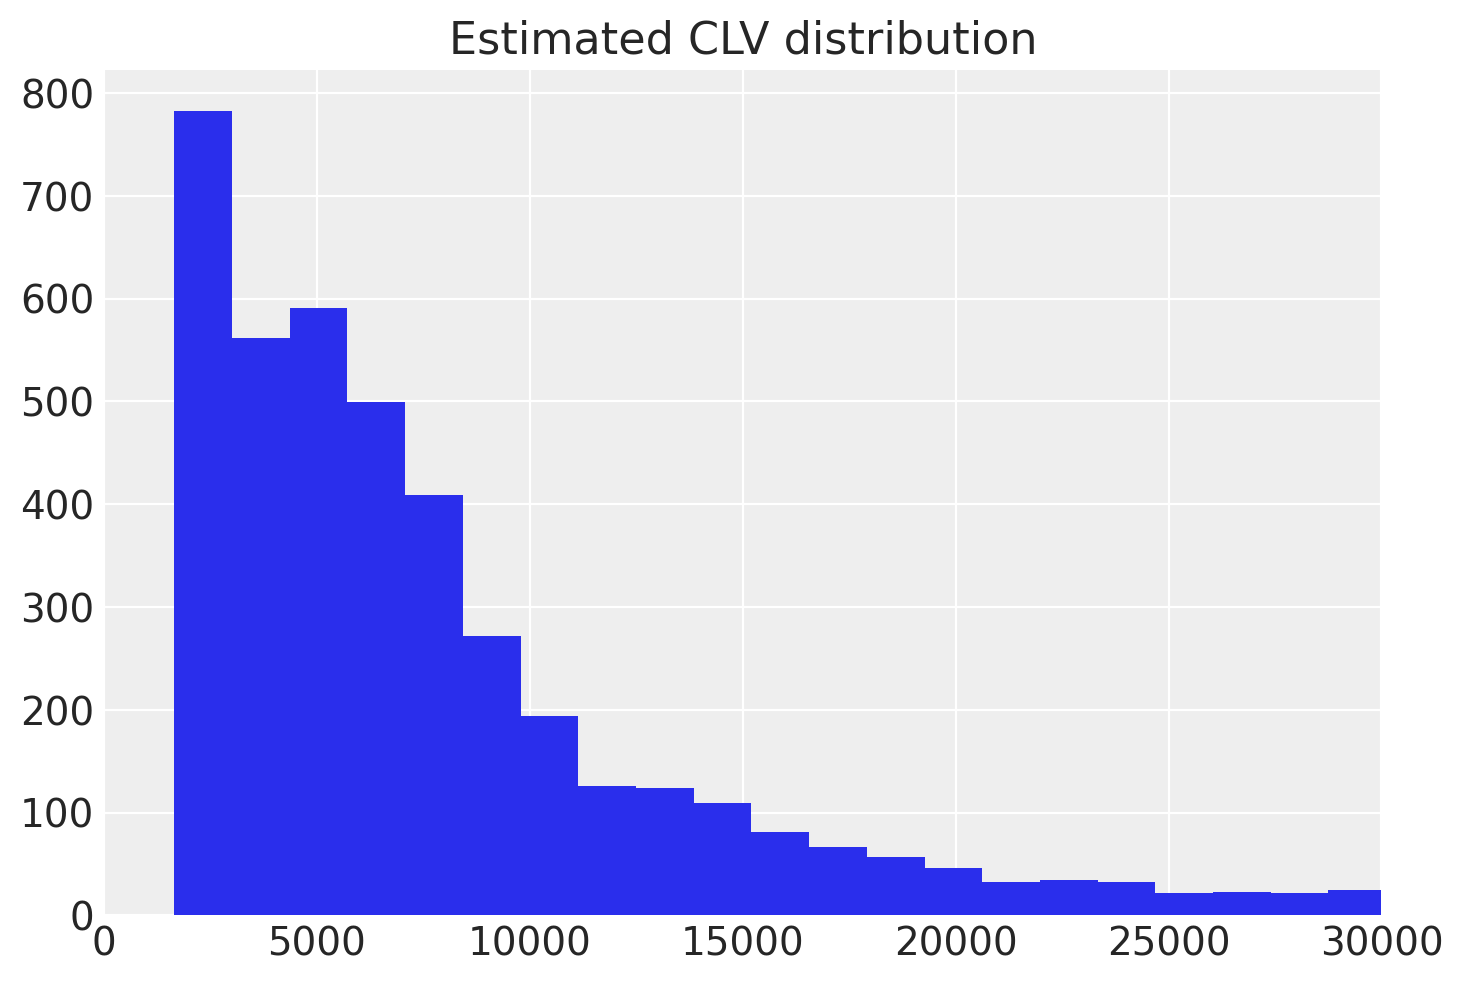

In [44]:
plt.hist(clv_df['clv_estimate'],bins=1000)
plt.xlim(0,30000)
plt.grid(True)
plt.title('Estimated CLV distribution')

In [45]:
clv_df_merged = pd.merge(data_summary_rfm.drop(columns=['customer_id','monetary_value']).reset_index(),clv_df,on='customer_id')

Text(0.5, 1.0, 'Frequency * estimated CLV')

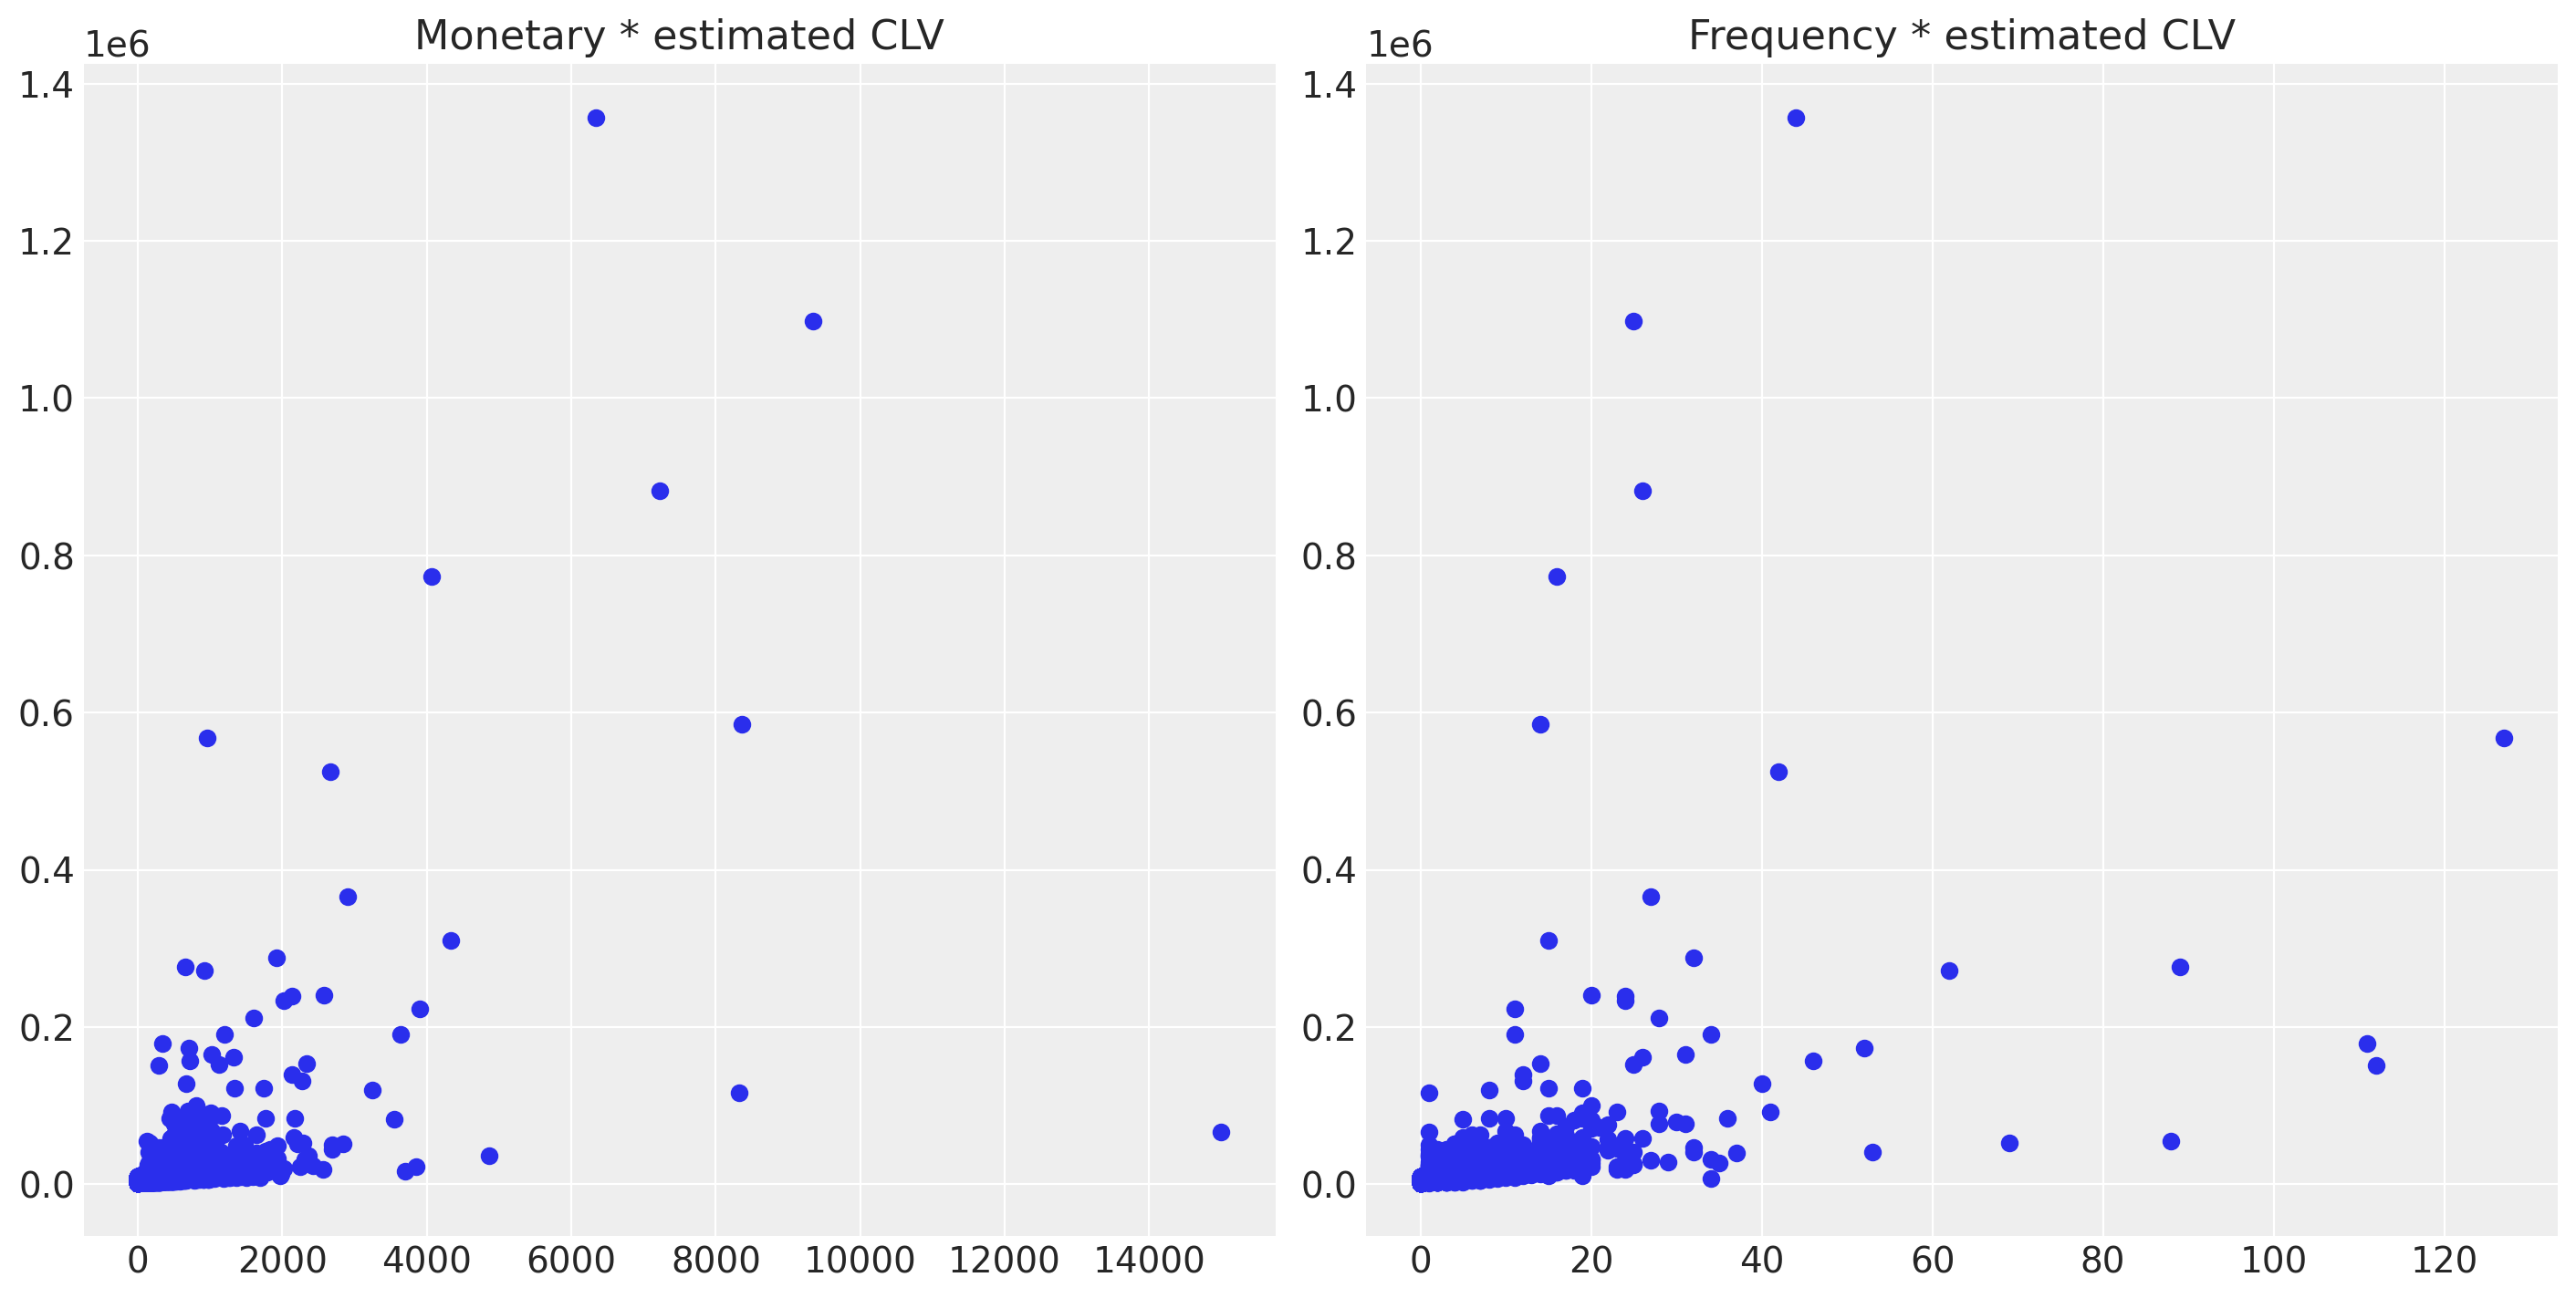

In [46]:
# relationship between monetary value and clv
fig, axes = plt.subplots(1,2,figsize=(14,7))
axes[0].scatter(clv_df_merged['monetary_value'],clv_df_merged['clv_estimate'])
axes[0].set_title('Monetary * estimated CLV')
# relationship between frequency and clv
axes[1].scatter(clv_df_merged['frequency'],clv_df_merged['clv_estimate'])
axes[1].set_title('Frequency * estimated CLV')

## Example of business marketing operation with estimated CLV

Now, we have expected CLV for each customer. Using the customer CLVs we could compute CLV by country. Based on the CLV by country, we could allocate our marketing budged for customer acquisition.

/tmp/ipykernel_663/4207509019.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  customer_sales = data.groupby('CustomerID').agg({


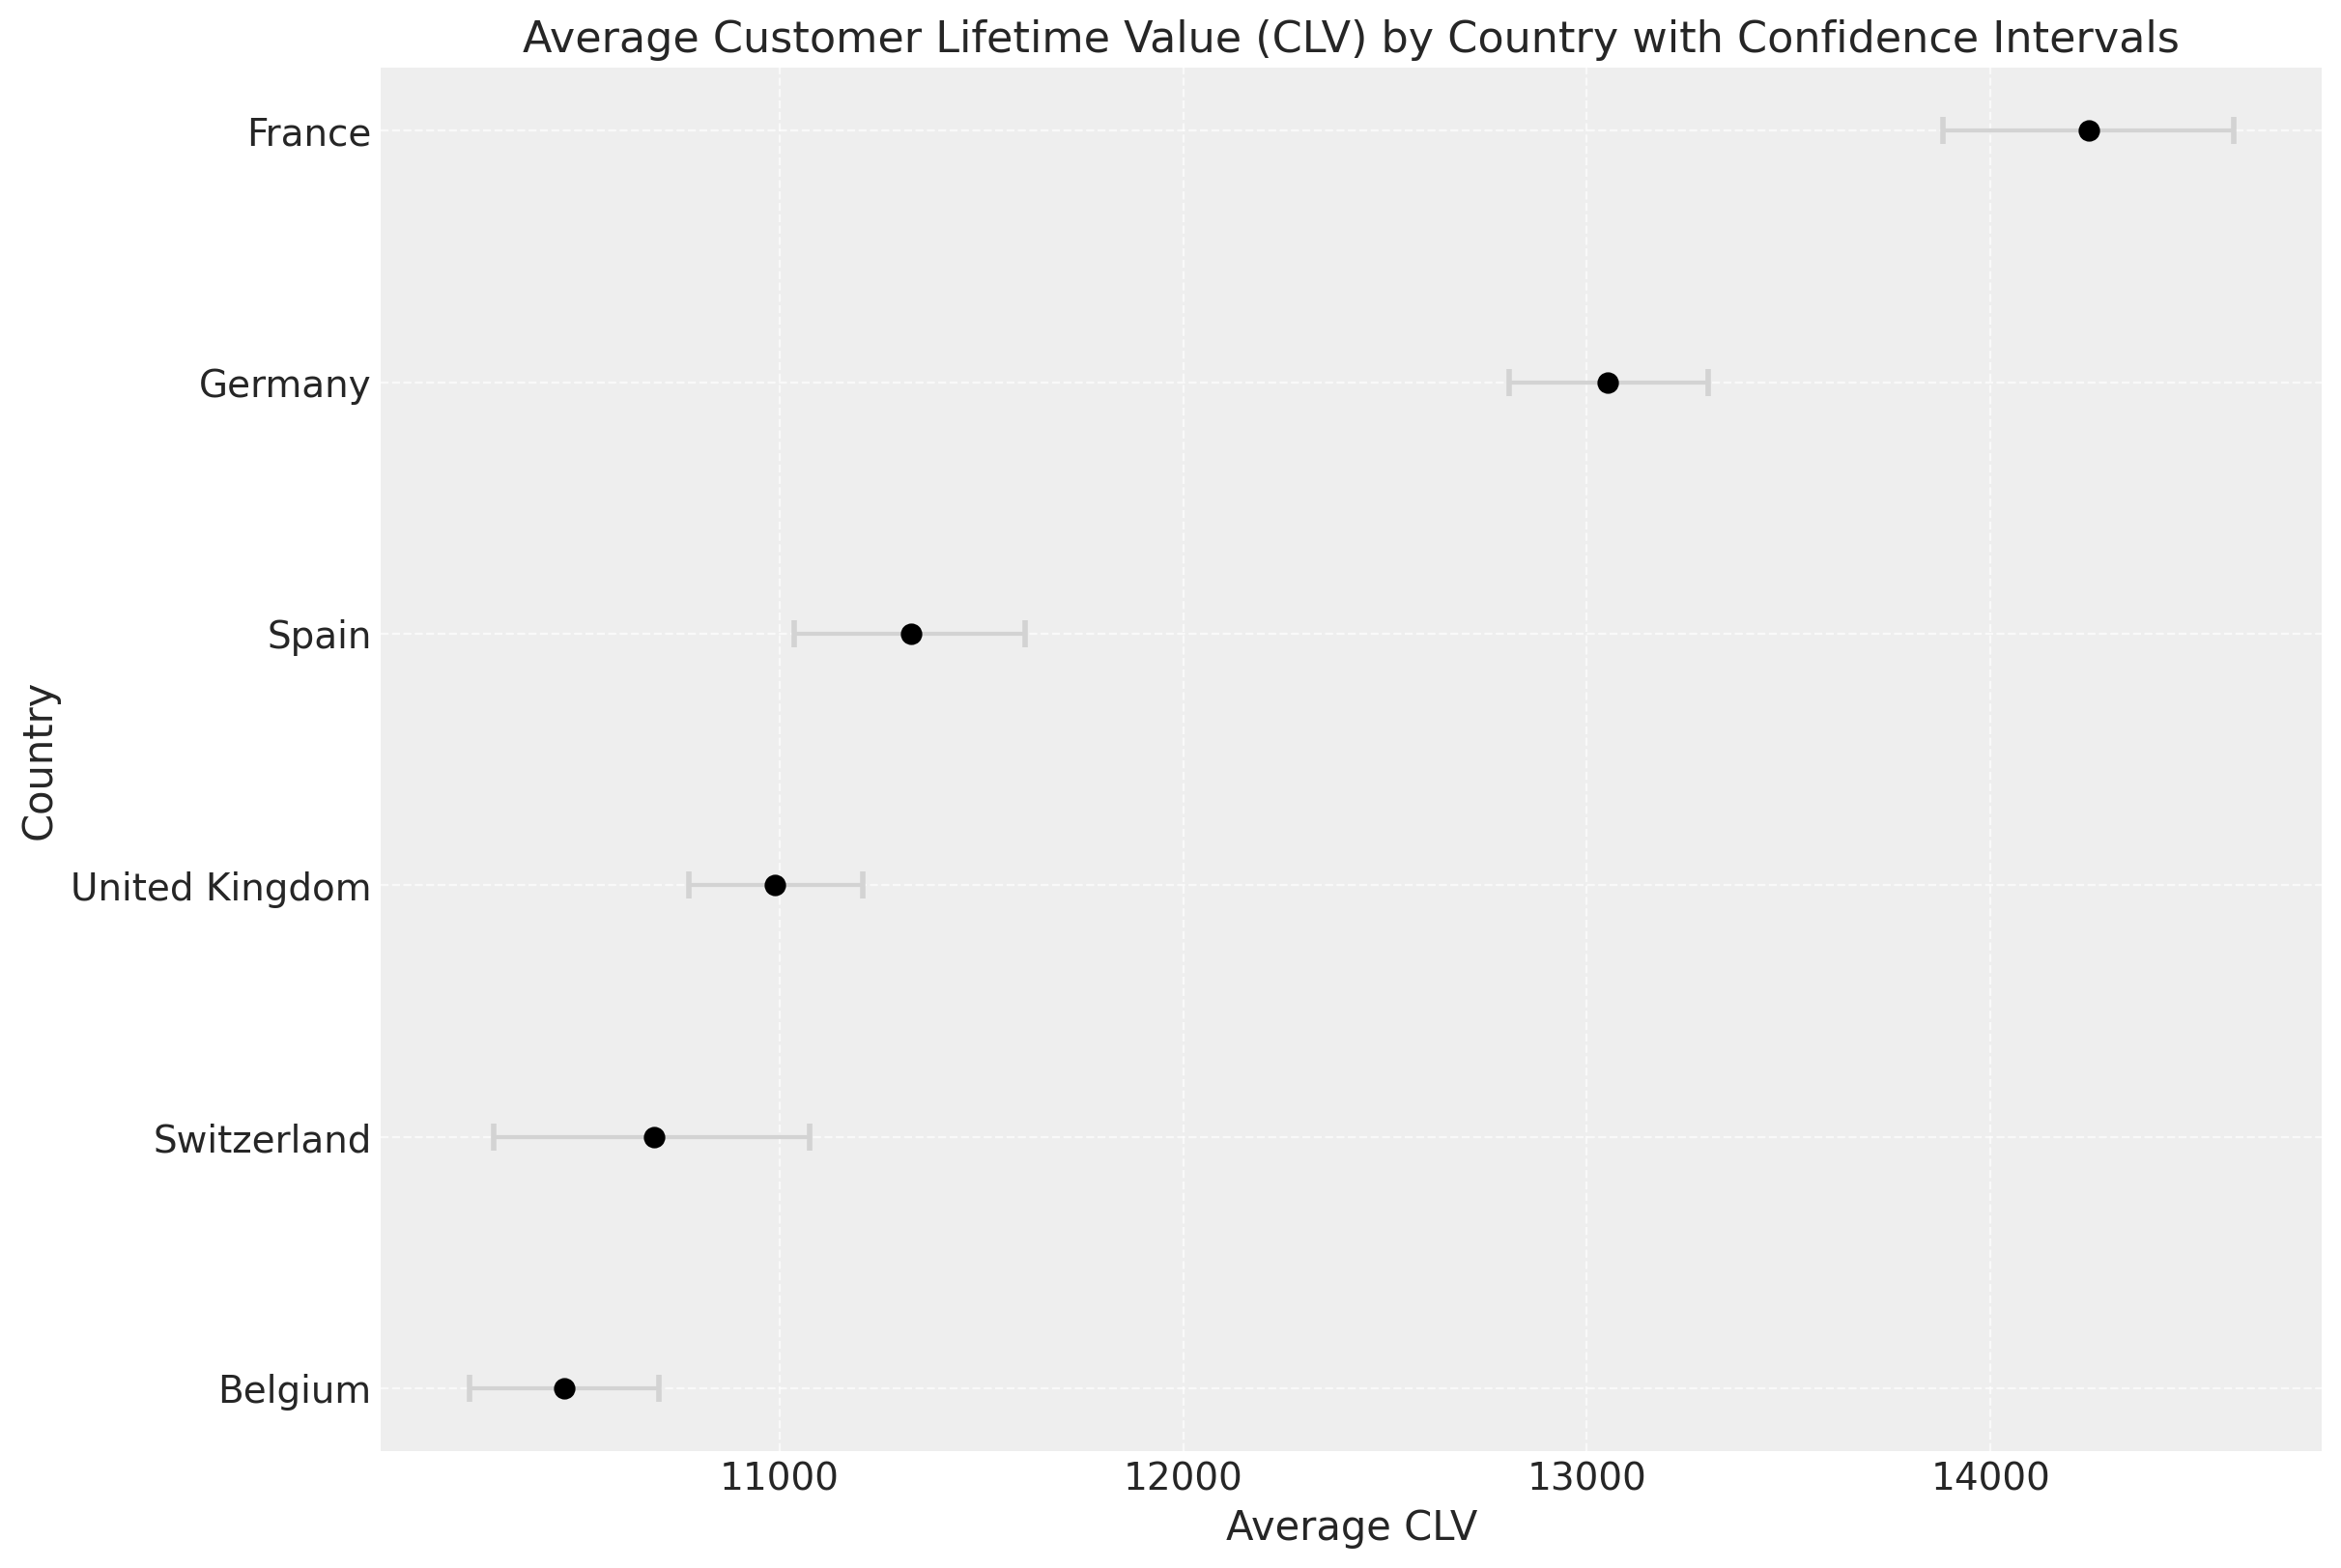

In [47]:
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
customer_sales = data.groupby('CustomerID').agg({
    'TotalSales': sum,
    'Country': 'first'
})

customer_countries = customer_sales.reset_index()[['CustomerID', 'Country']]

clv_with_country = pd.merge(clv_df, customer_countries, left_on='customer_id', right_on='CustomerID', how='left')

average_clv_by_country = clv_with_country.groupby('Country')['clv_estimate'].mean()

customer_count_by_country = data.groupby('Country')['CustomerID'].nunique()

country_clv_summary = pd.DataFrame({
    'AverageCLV': average_clv_by_country,
    'CustomerCount': customer_count_by_country,
})

# Calculate the average lower and upper bounds of the CLV estimates by country
average_clv_lower_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_3%'].mean()
average_clv_upper_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_97%'].mean()

country_clv_summary['AverageCLVLower'] = average_clv_lower_by_country
country_clv_summary['AverageCLVUpper'] = average_clv_upper_by_country

filtered_countries = country_clv_summary[country_clv_summary['CustomerCount'] >= 20]

sorted_countries = filtered_countries.sort_values(by='AverageCLV', ascending=False)

lower_error = sorted_countries['AverageCLV'] - sorted_countries['AverageCLVLower']
upper_error = sorted_countries['AverageCLVUpper'] - sorted_countries['AverageCLV']
asymmetric_error = [lower_error, upper_error]

plt.figure(figsize=(12,8))

plt.errorbar(x=sorted_countries['AverageCLV'], y=sorted_countries.index.tolist(),
             xerr=asymmetric_error, fmt='o', color='black', ecolor='lightgray', capsize=5, markeredgewidth=2)
plt.xlabel('Average CLV')
plt.ylabel('Country')
plt.title('Average Customer Lifetime Value (CLV) by Country with Confidence Intervals')  # chart title
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

From the graph above, France tends to have higher customer CLV while Belgium has the lowest CLV among them. Thus, we could decrease the budget for Belgium and increase the budget for France.

In this example, we calculate country -based CLV, but we could use states or regions data depending on your desired granularity of data.